# Training with scikit-learn

In [34]:
import os
import pickle

from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
from matplotlib import pyplot
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, auc, precision_recall_curve, f1_score
from sklearn.model_selection import train_test_split

In [2]:
data_dir = 'data_0419_0'
train_file_path = os.path.join(data_dir, 'train.csv')

In [3]:
train = pd.read_csv(train_file_path)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2821568 entries, 0 to 2821567
Data columns (total 25 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   coupon_used                  int64  
 1   cust_mean_buy_price          float64
 2   cust_total_coupons           float64
 3   cust_mean_discount           float64
 4   cust_unique_products         float64
 5   cust_unique_products_coupon  float64
 6   cust_total_products          float64
 7   coupon_discount              int64  
 8   coupon_how_many              int64  
 9   coupon_mean_prod_price       float64
 10  coupon_prods_avail           int64  
 11  cust_gender_F                int64  
 12  cust_gender_M                int64  
 13  cust_age_mid                 int64  
 14  cust_age_old                 int64  
 15  cust_age_young               int64  
 16  coupon_type_buy_all          int64  
 17  coupon_type_buy_more         int64  
 18  coupon_type_department       int64  
 19  

In [4]:
train.sample(10)

,coupon_used,cust_mean_buy_price,cust_total_coupons,cust_mean_discount,cust_unique_products,cust_unique_products_coupon,cust_total_products,coupon_discount,coupon_how_many,coupon_mean_prod_price,...,cust_age_young,coupon_type_buy_all,coupon_type_buy_more,coupon_type_department,coupon_type_just_discount,coupon_dpt_Boys,coupon_dpt_Girls,coupon_dpt_Men,coupon_dpt_Sport,coupon_dpt_Women
2144394,0,12.14,801.0,9.40,1580.0,541.0,2862.0,69,3,6.14,...,0,1,0,0,0,0,0,0,1,0
1628137,0,14.02,2753.0,11.99,2338.0,1081.0,8048.0,16,3,3.09,...,0,0,1,0,0,0,0,0,0,1
2402222,0,12.90,1972.0,10.04,2082.0,916.0,6640.0,42,5,8.81,...,0,1,0,0,0,0,0,1,0,0
6187,0,11.31,52.0,9.82,156.0,51.0,171.0,61,3,8.43,...,0,1,0,0,0,0,0,0,0,1
967636,0,13.63,2185.0,10.57,2113.0,1001.0,6950.0,18,5,5.23,...,0,0,1,0,0,0,0,1,0,0
2640588,0,12.63,1097.0,10.21,1766.0,657.0,4000.0,18,1,6.91,...,1,0,0,0,1,0,0,1,0,0
2812685,0,13.24,311.0,10.82,857.0,257.0,1076.0,23,3,9.60,...,0,0,1,0,0,0,0,1,0,0
521062,0,13.82,1978.0,11.67,2152.0,949.0,6160.0,9,1,8.03,...,0,0,0,0,1,0,0,0,1,0
2207723,0,14.38,631.0,9.60,1273.0,433.0,2078.0,18,1,6.04,...,0,0,0,0,1,1,0,0,0,0
80030,0,14.81,258.0,8.53,675.0,228.0,885.0,43,4,9.57,...,0,0,1,0,0,0,0,1,0,0


In [5]:
train.coupon_used.value_counts(normalize=True)

0    0.905772
1    0.094228
Name: coupon_used, dtype: float64

In [6]:
y_train = train['coupon_used']
X_train = train.drop(['coupon_used'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [7]:
X_all = X_train.append(X_test)
y_all = y_train.append(y_test)

In [8]:
def plot_pr_curve(probs, preds, y, legend=''):
    precision, recall, _ = precision_recall_curve(y, probs)
    f1_, auc_ = f1_score(y, preds), auc(recall, precision)
    # summarize scores
    print(f'{legend}:\nf1={round(f1_, 3)} auc={round(auc_, 3)}')
    # plot the precision-recall curves
    no_skill = len(y[y==1]) / len(y)
    pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    pyplot.plot(recall, precision, marker='.', label='GBM')
    # axis labels
    pyplot.xlabel('Recall')
    pyplot.ylabel('Precision')
    # show the legend
    pyplot.legend()
    # show the plot
    pyplot.show()

In [9]:
gbm_params = {
    'n_estimators': 65,
    'max_depth': 10,
    'max_leaf_nodes': 966
}

## 1. Training with no balancing

In [10]:
gbm = GradientBoostingClassifier(**gbm_params)
gbm.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=10, max_leaf_nodes=966, n_estimators=65)

#### 1.1. Evaluating on the test dataset

In [11]:
probs = gbm.predict_proba(X_test)[:, 1]
preds = gbm.predict(X_test)

GBM trained on an unbalanced dataset, evaluated on the test dataset:
f1=0.345 auc=0.403


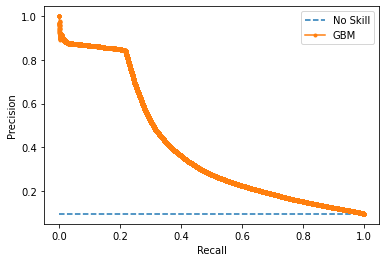

In [12]:
plot_pr_curve(probs, preds, y=y_test, legend='GBM trained on an unbalanced dataset, evaluated on the test dataset')

In [13]:
pd.crosstab(y_test, preds, rownames=['Actual'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
Actual,,,
0,508949,2193,511142
1,41614,11558,53172
All,550563,13751,564314


In [14]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96    511142
           1       0.84      0.22      0.35     53172

    accuracy                           0.92    564314
   macro avg       0.88      0.61      0.65    564314
weighted avg       0.92      0.92      0.90    564314



#### 1.2 Evaluating on the whole dataset

In [15]:
probs = gbm.predict_proba(X_all)[:, 1]
preds = gbm.predict(X_all)

GBM trained on an unbalanced dataset, evaluated on the whole dataset:
f1=0.351 auc=0.439


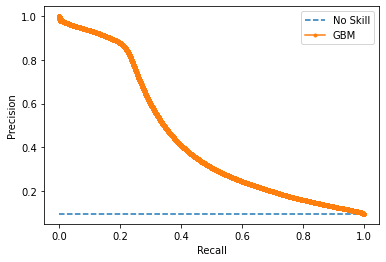

In [16]:
plot_pr_curve(probs, preds, y=y_all, legend='GBM trained on an unbalanced dataset, evaluated on the whole dataset')

In [17]:
pd.crosstab(y_all, preds, rownames=['Actual'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
Actual,,,
0,2544917,10779,2555696
1,207011,58861,265872
All,2751928,69640,2821568


In [18]:
print(classification_report(y_all, preds))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96   2555696
           1       0.85      0.22      0.35    265872

    accuracy                           0.92   2821568
   macro avg       0.88      0.61      0.65   2821568
weighted avg       0.92      0.92      0.90   2821568



#### 1.3. Pickle the model

In [19]:
with open(os.path.join(data_dir, 'pickled_model_gbm_no_balancing'), 'wb') as f:
    pickle.dump(gbm, f)

## 2. Training with balancing (SMOTE)

#### 3.1. Balancing

In [20]:
smote = SMOTE(sampling_strategy=0.5)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

In [21]:
y_train_sm.value_counts(normalize=True)

0    0.666667
1    0.333333
Name: coupon_used, dtype: float64

#### 3.2 Training

In [22]:
gbm_sm = GradientBoostingClassifier(**gbm_params)
gbm_sm.fit(X_train_sm, y_train_sm)

GradientBoostingClassifier(max_depth=10, max_leaf_nodes=966, n_estimators=65)

#### 3.3 Evaluating on the test dataset

In [23]:
probs = gbm_sm.predict_proba(X_test)[:, 1]
preds = gbm_sm.predict(X_test)

GBM trained on a balanced dataset (SMOTE), evaluated on the test dataset:
f1=0.365 auc=0.4


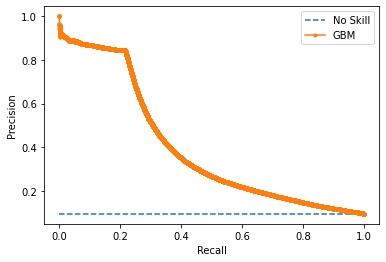

In [24]:
plot_pr_curve(probs, preds, y=y_test,
              legend='GBM trained on a balanced dataset (SMOTE), evaluated on the test dataset')

In [25]:
pd.crosstab(y_test, preds, rownames=['Actual'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
Actual,,,
0,505049,6093,511142
1,39947,13225,53172
All,544996,19318,564314


In [26]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96    511142
           1       0.68      0.25      0.36     53172

    accuracy                           0.92    564314
   macro avg       0.81      0.62      0.66    564314
weighted avg       0.90      0.92      0.90    564314



#### 3.4 Evaluating on the entire dataset

In [27]:
probs = gbm_sm.predict_proba(X_all)[:, 1]
preds = gbm_sm.predict(X_all)

GBM trained on a balanced dataset (SMOTE), evaluated on the whole dataset:
f1=0.372 auc=0.417


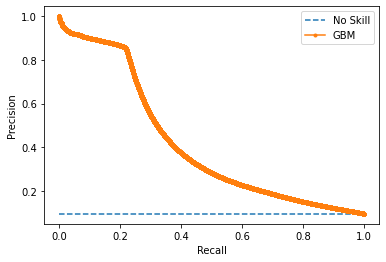

In [28]:
plot_pr_curve(probs, preds, y=y_all,
              legend='GBM trained on a balanced dataset (SMOTE), evaluated on the whole dataset')

In [29]:
pd.crosstab(y_all, preds, rownames=['Actual'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
Actual,,,
0,2525560,30136,2555696
1,198166,67706,265872
All,2723726,97842,2821568


In [30]:
print(classification_report(y_all, preds))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96   2555696
           1       0.69      0.25      0.37    265872

    accuracy                           0.92   2821568
   macro avg       0.81      0.62      0.66   2821568
weighted avg       0.91      0.92      0.90   2821568



#### 3.5 Calculate the best threshold

In [35]:
precision, recall, thresholds = precision_recall_curve(y_all, probs)
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={round(fscore[ix], 3)}')

Best Threshold=0.3321256069930437, F-Score=0.392


In [31]:
with open(os.path.join(data_dir, 'pickled_model_gbm_smote'), 'wb') as f:
    pickle.dump(gbm_sm, f)